# Joint fit for K2-28b: K2 and Diffuser-assisted transit

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
sns.set_context("poster",font_scale=1.2,rc={"font":"helvetica"});
sns.set_style("white"); #sns.set_style("ticks")
cp = sns.color_palette("colorblind") #sns.palplot(current_palette)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")

import getpass
# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try:
        sys.path.remove("/Users/gks/Dropbox/mypylib/notebooks/GIT/transitMCMC/src")
        sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print(e)
        print("Paths already removed")
        
from priors import PriorSet, UP, NP, JP
import tf
import pyde
import mcmc_utils
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es, ll_normal_ev
import batman
import math
import epicblsmulti
import k2help
import utils

# Read Saved K2 data from K2-only analysis

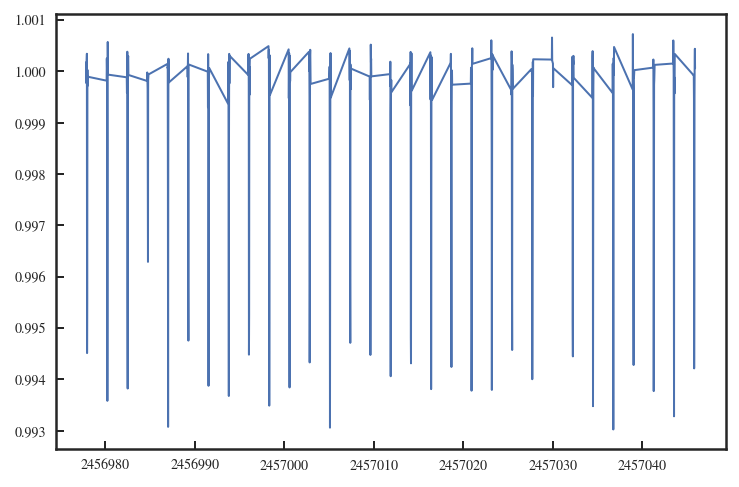

In [5]:
dfmm_s = pd.read_csv("../data/k2_28b/K2_data_k2_28b_final.csv")
# Inspect full data
dfmm_s = dfmm_s.sort_values("index")
plt.plot(dfmm_s.time,dfmm_s.y)

# Read Ground Based 

In [6]:
df_ground = pd.read_csv("../data/k2_28b/Processed_K2-28b-diffuserin-30s_measurements.xls",sep="\t")

In [7]:
# Define variables
t_ground = df_ground.BJD_TDB.values
f_ground = df_ground.rel_flux_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)
err_ground = df_ground.rel_flux_err_T1.values/np.nanmedian(df_ground.rel_flux_T1.values)

# Other params
NREFSTARS = 3.
cadence = np.median(np.diff(t_ground))*24.*60.*60.
print("Cadence {}s".format(cadence))

# Calculate the mean values for scintillation and photon to plot on the plot
final_unbinned_scint_noise = utils.scintillation_noise(350.,np.mean(df_ground["AIRMASS"]),cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
final_unbinned_phot_noise = np.mean(df_ground.rel_flux_err_T1)
print("Mean photon error: {}".format(final_unbinned_phot_noise))
print("Mean scint error: {} calculated for mean airmass of {}".format(final_unbinned_scint_noise,np.mean(df_ground["AIRMASS"])))

# Calculate full array of errors including scintilation
scint_error = utils.scintillation_noise(350.,df_ground.AIRMASS.values,cadence,2700.,withextra=True)*np.sqrt(1.+1./NREFSTARS)
tot_error = np.sqrt(scint_error**2.+err_ground**2.)

Cadence 32.5728267431s
Mean photon error: 0.000451952380952
Mean scint error: 0.000619102949387 calculated for mean airmass of 1.58181448485


### Calculate Scintillation errorbars

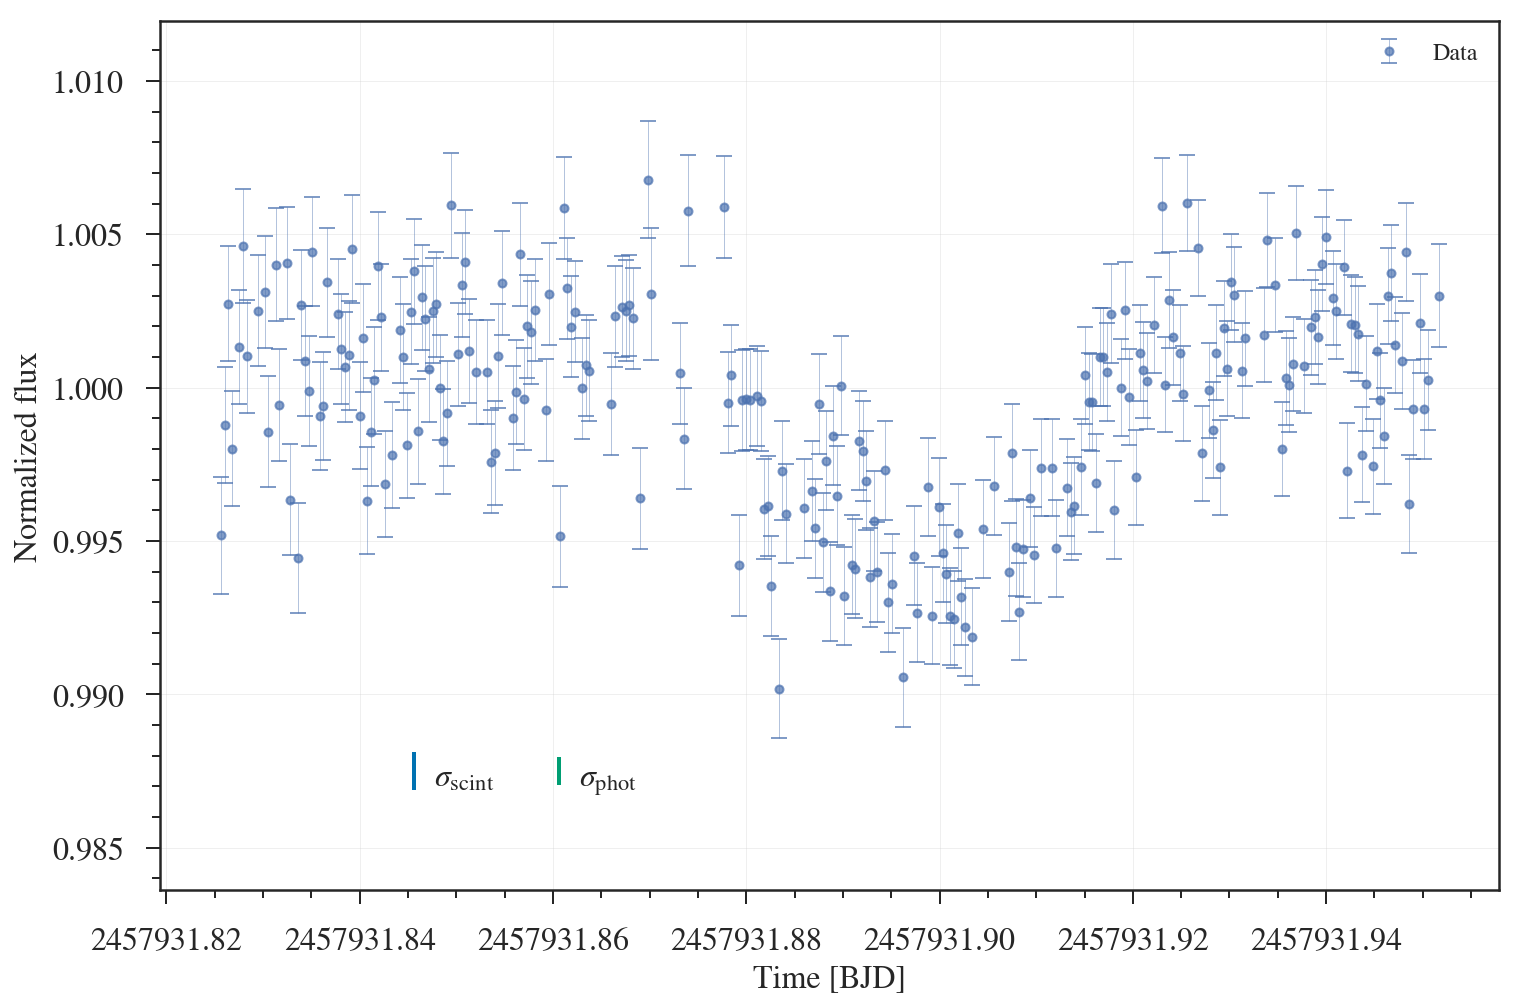

In [8]:
import plot_transits
fig, ax = plt.subplots(figsize=(12,8))
plot_transits.plot_transit_with_model(t_ground,f_ground,tot_error,ax=ax)
x0 = t_ground[0]
ax.errorbar(x0+0.01+0.01,0.9975-0.01,yerr=final_unbinned_scint_noise,elinewidth=2,color=cp[0],mew=0.5)
ax.errorbar(x0+0.025+0.01,0.9975-0.01,yerr=final_unbinned_phot_noise,elinewidth=2,color=cp[1],mew=0.5)
ax.text(x0+0.01+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{scint}}$",fontsize=16)
ax.text(x0+0.025+0.01+0.002,0.99741-0.0104,r"$\sigma_{\mathrm{phot}}$",fontsize=16)

ax.set_xlabel("Time [BJD]",fontsize=16)
ax.set_ylabel("Normalized flux",fontsize=16)
ax.minorticks_on()
ax.legend(loc="upper right",fontsize=12)
ax.margins(x=0.05,y=0.15)
ax.grid(lw=0.5,alpha=0.3)

ax.tick_params(axis="both",labelsize=16)

In [22]:
# Period from K2 fit
_p = np.log10(2.260443)

In [23]:
class LPFunction(object):
    """
    Log-Likelihood function class
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    """
    def __init__(self):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.data1= {"time"  : dfmm_s.time.values,  # phase folded time in days (centered on 0)
                    "flux"   : dfmm_s.y.values   # phase folded flux
                    }
        self.data2= {"time" : t_ground,
                     "flux" : f_ground,
                     "error": tot_error
                    }
        #####
        
        # Setting priors
        self.priors = [UP( 2457931.90-0.05     , 2457931.90+0.05        , 'tc'       ,r'$T_C$'                ,priortype="model"),  ##   5 - Transit centre, Tc
                       UP( _p  -0.002          , _p  +0.002             , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   0 - log(P)
                       UP( 0.                  , 0.2                    , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   1 - cos(i)
                       UP( 0.0                 , 0.1                    , 'RpRs_1'   ,r'$R_p/R_s$1'             ,priortype="model"),  ##   6 - rp/rstar
                       UP( 0.9                 , 2.0                    , 'log(a/Rs)',r'$\log(a/R_s)$2'         ,priortype="model"),  ##   2 - log(a/rstar)
                       UP( 0.0                 , 0.1                    , 'RpRs_2'   ,r'$R_p/R_s$2'            ,priortype="model"),  ##   7 - rp/rstar
                       #UP( 0.                  , 1.                     , 'q1_1'     ,r'$q_1$1'                ,priortype="model"),  ##   8 - q1
                       #UP( 0.                  , 1.                     , 'q2_1'     ,r'$q_2$1'                ,priortype="model"),  ##   9 - q2
                       #UP( 0.                  , 1.                     , 'q1_2'     ,r'$q_1$2'                ,priortype="model"),  ##   10 - q1
                       #UP( 0.                  , 1.                     , 'q2_2'     ,r'$q_2$2'                ,priortype="model"),  ##   11 - q2
                       UP( 0.9                 , 1.1                    , 'fraw1'    ,r'fraw1'                 ,priortype="baseline1"),## 12 - Baseline constant
                       UP( 0.9                 , 1.1                    , 'fraw2'    ,r'fraw2'                 ,priortype="baseline2"),
                       UP( 1e-5                , 50e-5                  , 'err1'     ,r'error1'                ,priortype="error1")]## 13 - Baseline constant
        
        self.ps     = PriorSet(self.priors)
        print("Baseline1 is at pv=",self.pv_lab2Idx("fraw1"))
        print("Baseline2 is at pv=",self.pv_lab2Idx("fraw2"))
        print("Error is at pv=",self.pv_lab2Idx("err1"))
        
    def pv_lab2Idx(self,pv_label):
        return np.where(np.array(self.ps.labels)==pv_label)[0][0]
            
    def compute_transit(self,pv,times1=None,times2=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        # First transit, K2
        self.params1 = batman.TransitParams()
        self.params1.t0 = pv[self.pv_lab2Idx("tc")]
        self.params1.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params1.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params1.rp = pv[self.pv_lab2Idx("RpRs_1")]
        self.params1.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params1.ecc = 0.
        self.params1.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_1")], pv[self.pv_lab2Idx("q2_1")]
        #self.params1.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params1.u = [0.4266, 0.3076]
        self.params1.limb_dark = "quadratic"
        self.params1.fp = 0.001
        if times1 is None:
            times1 = self.data1["time"]
        transitmodel = batman.TransitModel(self.params1, times1, transittype='primary',supersample_factor=7,exp_time=0.020431801470066003)
        self.lc1 = transitmodel.light_curve(self.params1)
        
        # Second transit, ground,
        self.params2 = batman.TransitParams()
        self.params2.t0 = pv[self.pv_lab2Idx("tc")]
        self.params2.per = 10.**pv[self.pv_lab2Idx("logP")]
        self.params2.inc = np.arccos(pv[self.pv_lab2Idx("cos(i)")])*180./math.pi
        self.params2.rp = pv[self.pv_lab2Idx("RpRs_2")]
        self.params2.a = 10.**pv[self.pv_lab2Idx("log(a/Rs)")]
        self.params2.ecc = 0.
        self.params2.w = 0.
        #q1, q2 = pv[self.pv_lab2Idx("q1_2")], pv[self.pv_lab2Idx("q2_2")]
        #self.params2.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        self.params2.u = [0.3402,0.3155]
        self.params2.limb_dark = "quadratic"
        self.params2.fp = 0.001
        if times2 is None:
            times2 = self.data2["time"]
        transitmodel = batman.TransitModel(self.params2, times2, transittype='primary')
        self.lc2 = transitmodel.light_curve(self.params2)
        return self.lc1, self.lc2      
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data2["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            detrend += pv[i]*(self.data2[self.ps.labels[i]]-1.)
        return detrend/pv[self.pv_lab2Idx("fraw2")]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
            pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
            The full light curve model with a trend
        """
        f1, f2 = self.compute_transit(pv)
        # Return the flux from K2, and then detrended flux from ground
        return f1, f2 + self.detrend(pv)
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        NOTES:
            This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m1, flux_m2 = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        
        scaled_flux1  = self.data1["flux"]/pv[self.pv_lab2Idx("fraw1")]
        scaled_flux2  = self.data2["flux"]/pv[self.pv_lab2Idx("fraw2")]
        
        log_of_model1  = ll_normal_es(scaled_flux1, flux_m1, pv[self.pv_lab2Idx("err1")])
        log_of_model2  = ll_normal_ev(scaled_flux2, flux_m2, self.data2["error"])

        log_ln = log_of_priors + log_of_model1 + log_of_model2
        
        return log_ln

# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above

In [28]:
import trf
TF = trf.TransitFit(LPFunction)

Baseline1 is at pv= 6
Baseline2 is at pv= 7
Error is at pv= 8


## Maximum likilihood solution, before doing MCMC

In [25]:
TF.minimize_PyDE(mcmc=False)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06  2.507487e-03
1       logP  3.541936e-01  3.521936e-01  3.561936e-01  3.541932e-01  3.171011e-07
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  1.856218e-02  8.143782e-02
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  6.870037e-02 -1.870037e-02
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.316750e+00  1.332495e-01
5     RpRs_2  5.000000e-02  0.000000e+00  1.000000e-01  8.027747e-02 -3.027747e-02
6      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  9.993365e-01  6.635019e-04
7      fraw2  1.000000e+00  9.000000e-01  1.100000e+00  1.000904e+00 -9.035003e-04
8       err1  2.550000e-04  1.000000e-05  5.000000e-04  4.999195e-04 -2.449195e-04
LogLn value: -2653.328723164333
Log priors 24.78332492492725


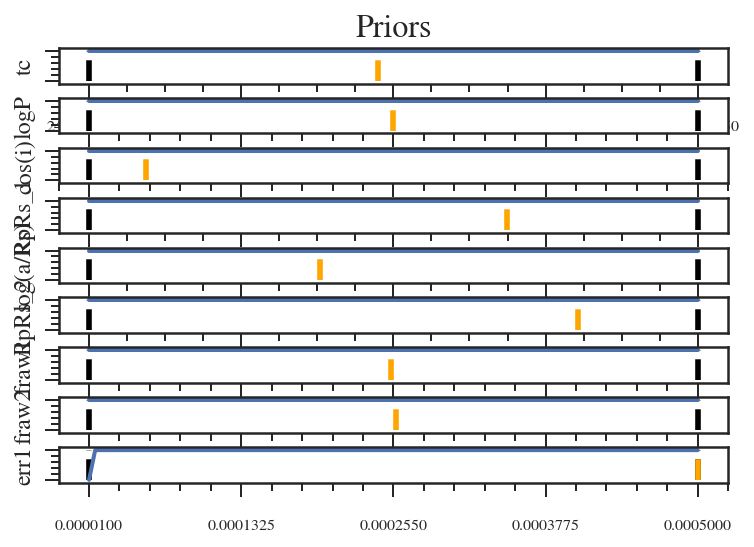

In [26]:
TF.lpf.ps.plot_all(TF.min_pv)

In [44]:
#### Solution doesn't look perfect

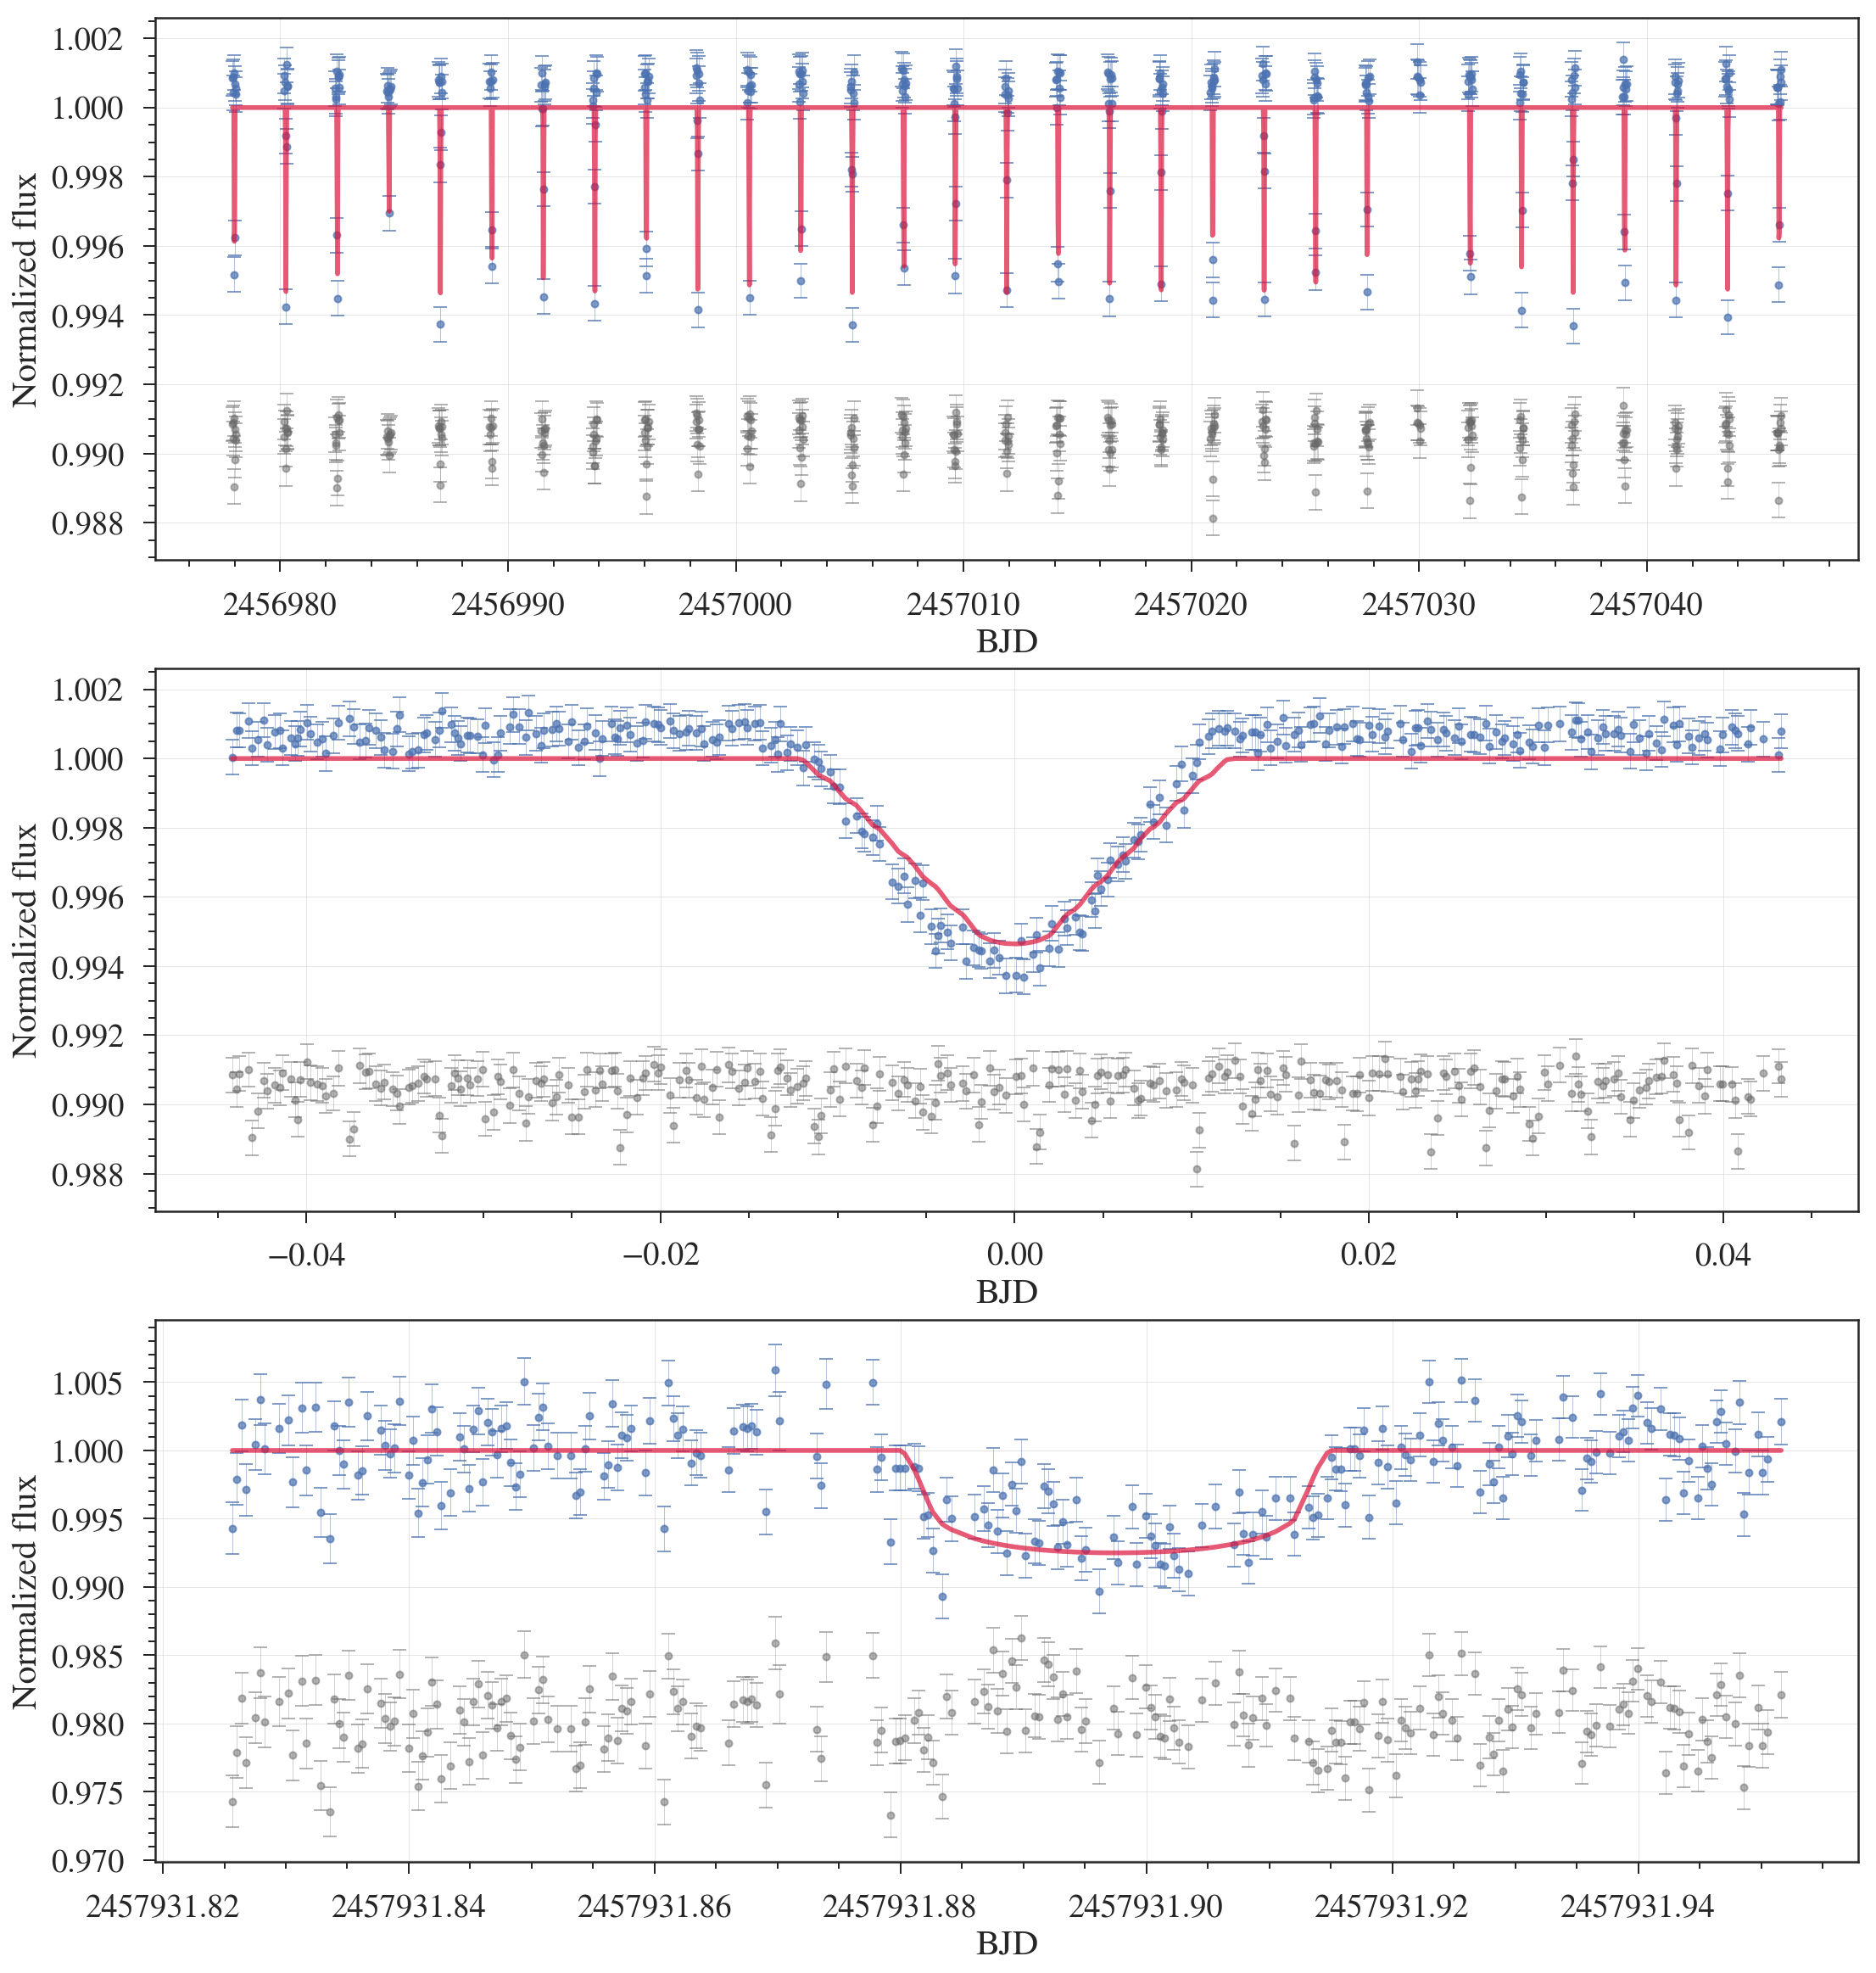

In [27]:
pv = TF.min_pv
t0  = pv[0]
p  = 10.**(pv[1])
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,20))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

# Run MCMC

In [30]:
TF.minimize_PyDE(mc_iter=10000)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv  center_dist
0         tc  2.457932e+06  2.457932e+06  2.457932e+06  2.457932e+06     0.001532
1       logP  3.541936e-01  3.521936e-01  3.561936e-01  3.541946e-01    -0.000001
2     cos(i)  1.000000e-01  0.000000e+00  2.000000e-01  2.179119e-02     0.078209
3     RpRs_1  5.000000e-02  0.000000e+00  1.000000e-01  7.690109e-02    -0.026901
4  log(a/Rs)  1.450000e+00  9.000000e-01  2.000000e+00  1.280075e+00     0.169925
5     RpRs_2  5.000000e-02  0.000000e+00  1.000000e-01  7.620570e-02    -0.026206
6      fraw1  1.000000e+00  9.000000e-01  1.100000e+00  1.000031e+00    -0.000031
7      fraw2  1.000000e+00  9.000000e-01  1.100000e+00  1.000929e+00    -0.000929
8       err1  2.550000e-04  1.000000e-05  5.000000e-04  4.985223e-04    -0.000244
LogLn value: -2917.8637491875456
Log priors 24.78332492492725
Running MCMC
MCMC iterations= 10000


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338 5339 5340 5341 

6783 6784 6785 6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976 6977 6978 6979 6980 6981 6982 

8423 8424 8425 8426 8427 8428 8429 8430 8431 8432 8433 8434 8435 8436 8437 8438 8439 8440 8441 8442 8443 8444 8445 8446 8447 8448 8449 8450 8451 8452 8453 8454 8455 8456 8457 8458 8459 8460 8461 8462 8463 8464 8465 8466 8467 8468 8469 8470 8471 8472 8473 8474 8475 8476 8477 8478 8479 8480 8481 8482 8483 8484 8485 8486 8487 8488 8489 8490 8491 8492 8493 8494 8495 8496 8497 8498 8499 8500 8501 8502 8503 8504 8505 8506 8507 8508 8509 8510 8511 8512 8513 8514 8515 8516 8517 8518 8519 8520 8521 8522 8523 8524 8525 8526 8527 8528 8529 8530 8531 8532 8533 8534 8535 8536 8537 8538 8539 8540 8541 8542 8543 8544 8545 8546 8547 8548 8549 8550 8551 8552 8553 8554 8555 8556 8557 8558 8559 8560 8561 8562 8563 8564 8565 8566 8567 8568 8569 8570 8571 8572 8573 8574 8575 8576 8577 8578 8579 8580 8581 8582 8583 8584 8585 8586 8587 8588 8589 8590 8591 8592 8593 8594 8595 8596 8597 8598 8599 8600 8601 8602 8603 8604 8605 8606 8607 8608 8609 8610 8611 8612 8613 8614 8615 8616 8617 8618 8619 8620 8621 8622 

Plotting chains


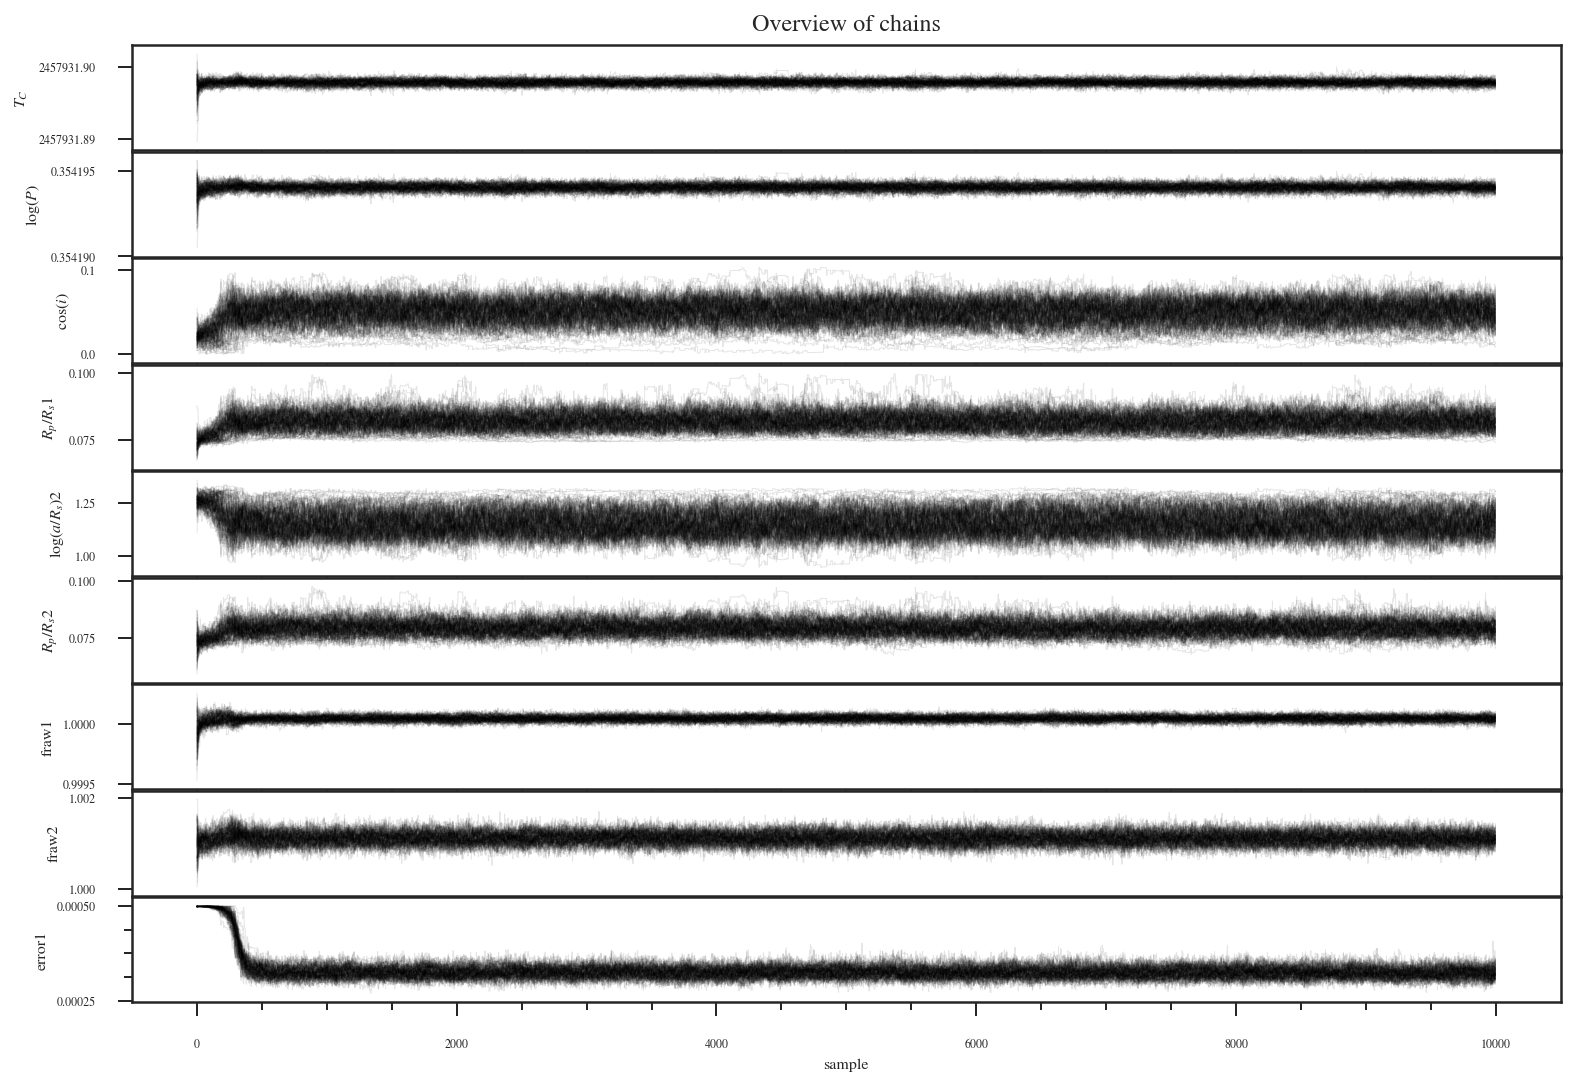

In [31]:
TF.plot_chains(burn=0)

Plotting cornerplot


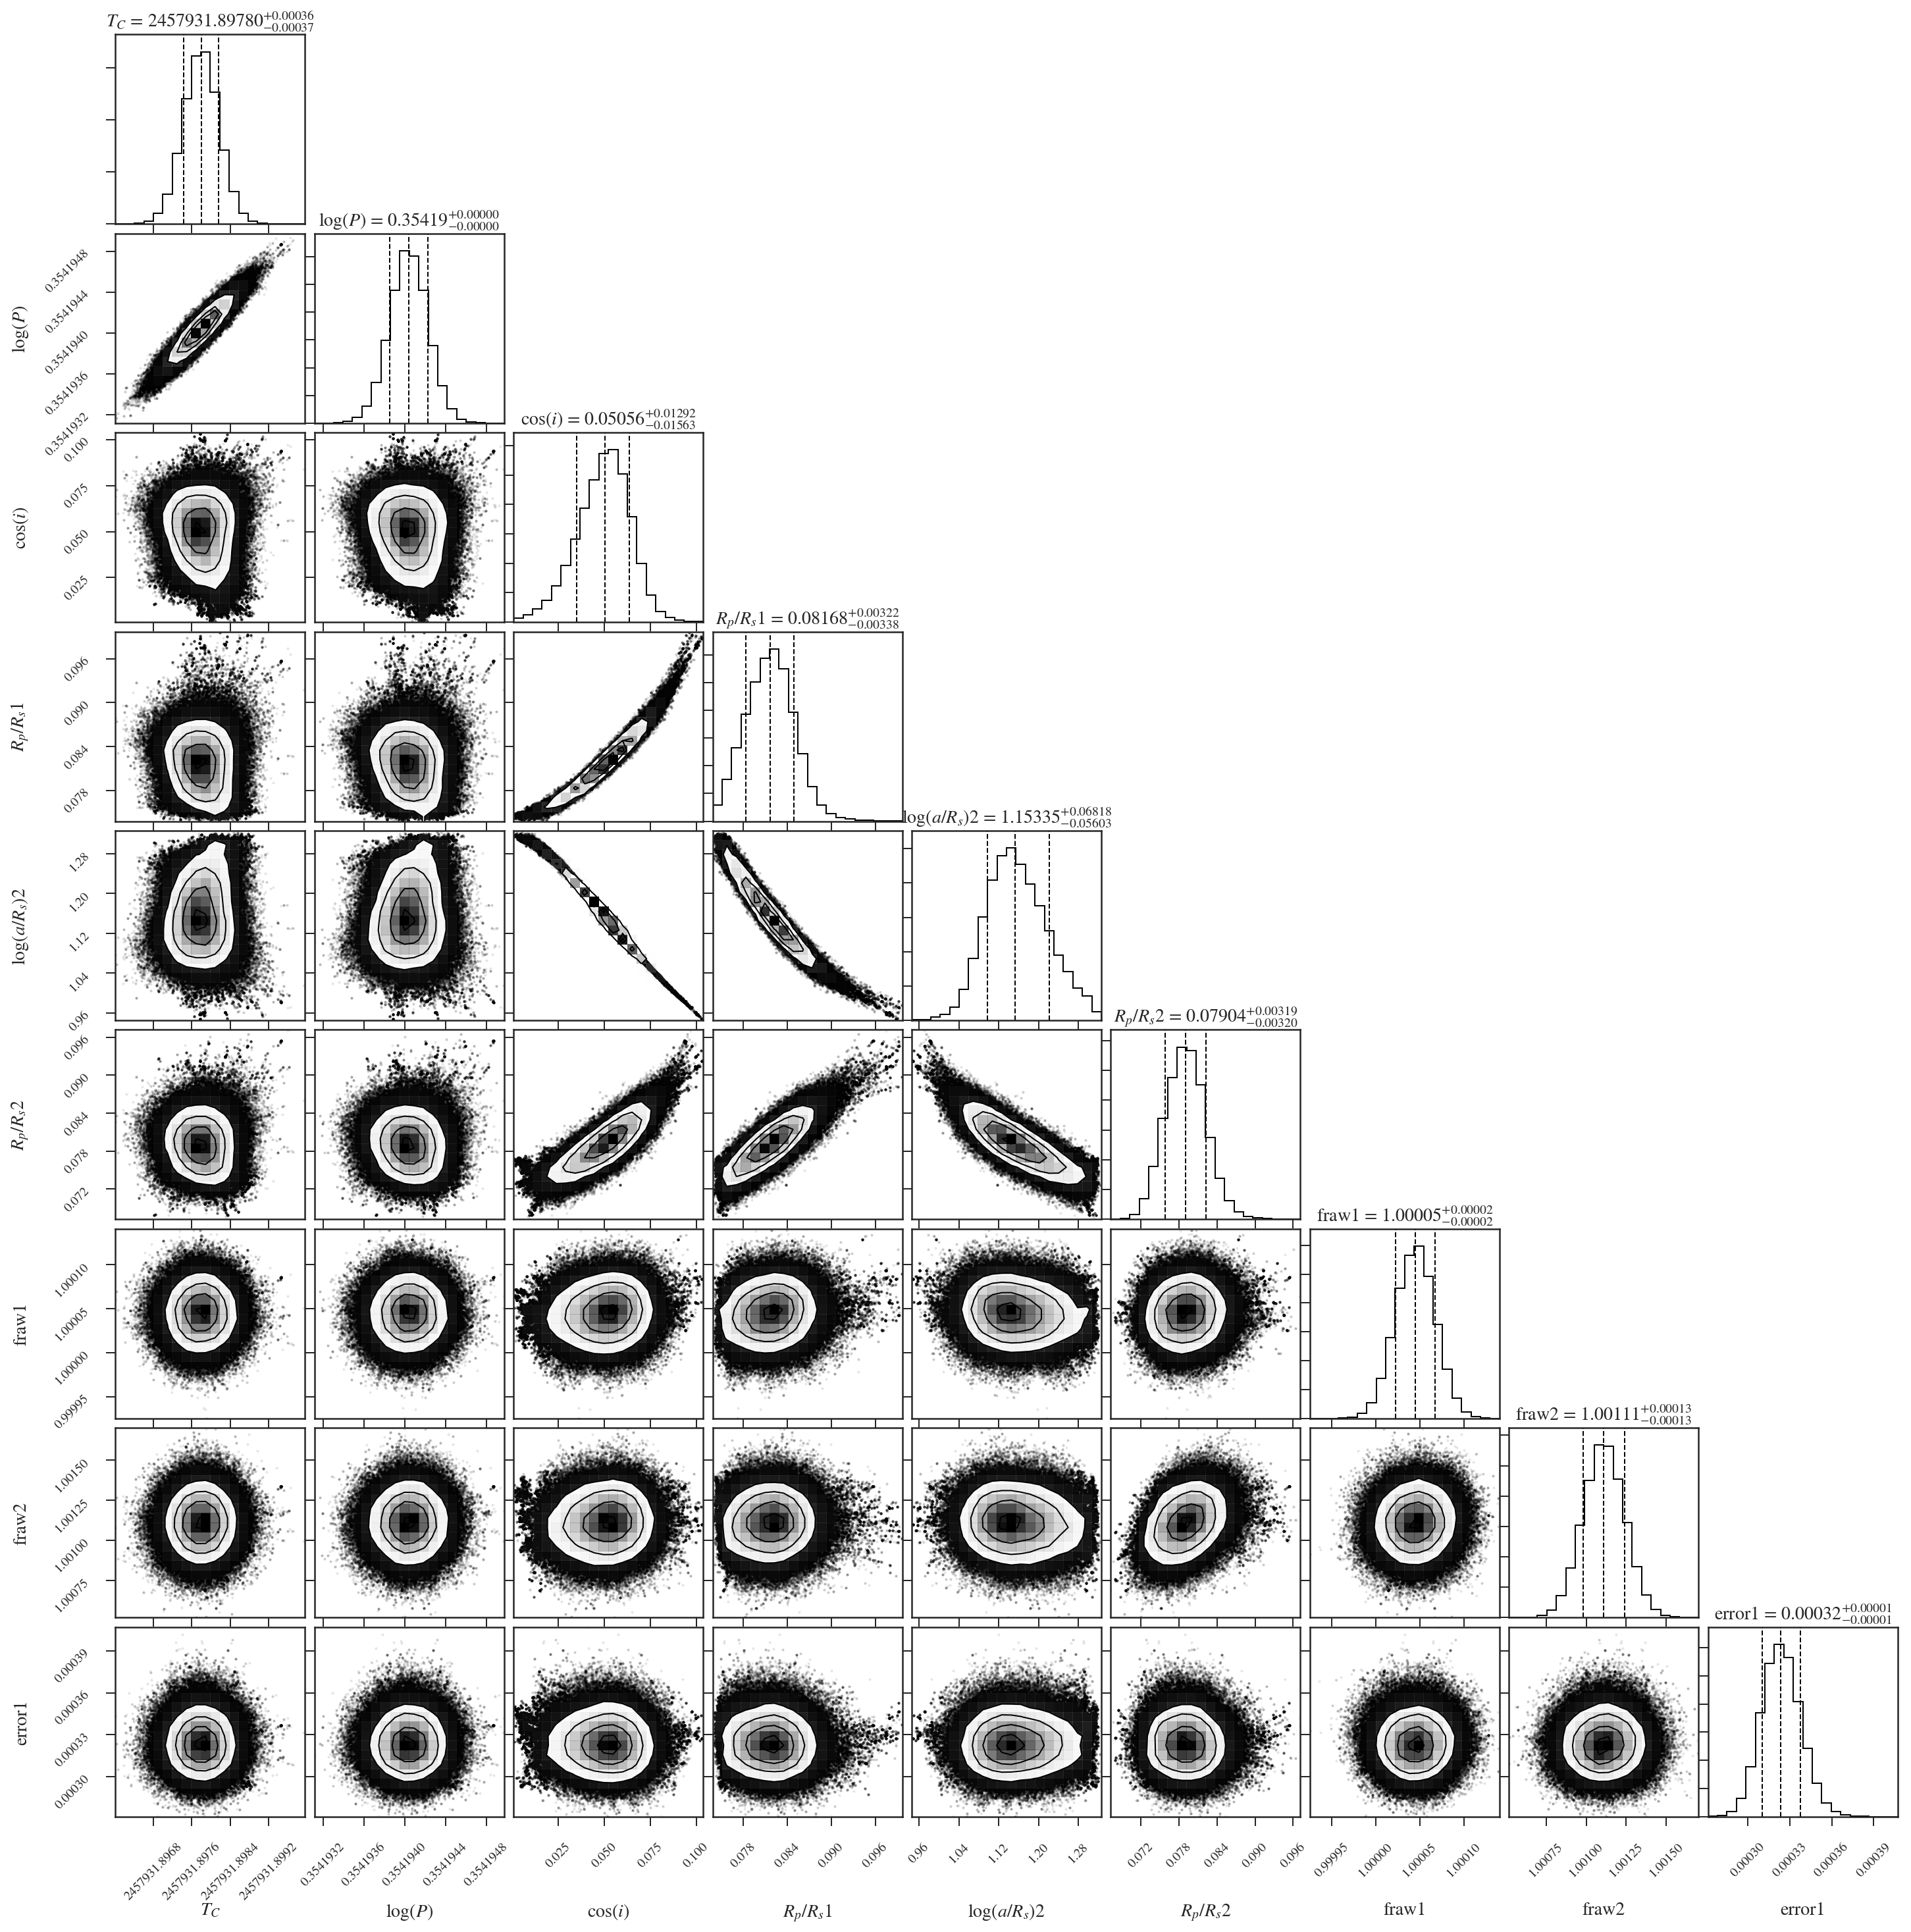

In [32]:
TF.plot_corner(burn=2000,show_titles=True)

In [34]:
TF.gelman_rubin(burn=2000)

array([1.01502095, 1.01543946, 1.06100132, 1.04002035, 1.0494264 ,
       1.0283088 , 1.00914165, 1.00849768, 1.00703487])

# Get planet parameters from chains

In [35]:
df = TF.get_df_flatchain(burn=2000)

In [36]:
df["P"] = 10.**df["logP"].values
df["i"] = np.rad2deg(np.arccos(df["cos(i)"].values))
df["aRs"] = 10.**df["log(a/Rs)"].values
# K2 parameters
df_param_k2 = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_1'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)
# Ground based parameters
df_param_ground = TF.get_transit_parameters_from_arrays(df['tc'].values,
                                                 df['P'].values,
                                                 df['i'].values,
                                                 df['RpRs_2'].values,
                                                 df['aRs'].values,
                                                 st_rad=0.288,
                                                 st_raderr1=0.028,
                                                 st_teff=3214.,
                                                 st_teff_err1=60.)

Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3
Assuming
R_s: 0.288 +- 0.028
Teff: 3214.0 +- 60.0
Albedo: 0.3


### Ground-based parameters

In [37]:
df_param_ground

medvals         minus          plus  \
0   2.457932e+06  3.675311e-04  3.626053e-04   
1   2.260445e+00  9.679859e-07  9.564029e-07   
2   7.903869e-02  3.196784e-03  3.193457e-03   
3   2.480301e+00  2.563520e-01  2.644258e-01   
4   2.212780e-01  2.287023e-02  2.359053e-02   
5   6.247114e-03  4.951198e-04  5.150115e-04   
6   1.423468e+01  1.722909e+00  2.419836e+00   
7   1.908981e-02  2.917690e-03  3.730082e-03   
8   1.067842e+01  3.427040e+00  6.424129e+00   
9   8.710207e+01  7.415840e-01  8.964731e-01   
10  7.197414e-01  1.380102e-01  7.476266e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.213355e+02  3.245517e+01  2.946458e+01   
14  2.187156e+01  5.999568e+00  6.790244e+00   
15  4.070344e-02  1.595683e-03  1.703882e-03   
16  5.813628e-03  1.750047e-03  2.087164e-03   
17  2.457933e+06  3.679674e-04  3.630975e-04   

                                   values  \
0    $2457931.8978_{-0.00037}^{+0.00036}$   
1   $2.2604455_{-0.0000010}^{+0.0000010}$   
2             $0.079_{-0.0032}^{+0.0032}$   
3                  $2.48_{-0.26}^{+0.26}$   
4               $0.221_{-0.023}^{+0.024}$   
5         $0.00625_{-0.00050}^{+0.00052}$   
6                    $14.2_{-1.7}^{+2.4}$   
7            $0.0191_{-0.0029}^{+0.0037}$   
8                    $10.7_{-3.4}^{+6.4}$   
9                  $87.1_{-0.74}^{+0.90}$   
10                $0.72_{-0.14}^{+0.075}$   
11                    $0.0_{-0.0}^{+0.0}$   
12                    $0.0_{-0.0}^{+0.0}$   
13                $421.0_{-32.0}^{+29.0}$   
14                   $21.9_{-6.0}^{+6.8}$   
15           $0.0407_{-0.0016}^{+0.0017}$   
16           $0.0058_{-0.0018}^{+0.0021}$   
17  $2457933.02802_{-0.00037}^{+0.00036}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

### Parameters from K2 

In [38]:
df_param_k2

medvals         minus          plus  \
0   2.457932e+06  3.675311e-04  3.626053e-04   
1   2.260445e+00  9.679859e-07  9.564029e-07   
2   8.167538e-02  3.382799e-03  3.217955e-03   
3   2.562095e+00  2.642478e-01  2.728329e-01   
4   2.285752e-01  2.357465e-02  2.434057e-02   
5   6.670868e-03  5.411395e-04  5.360106e-04   
6   1.423468e+01  1.722909e+00  2.419836e+00   
7   1.909580e-02  2.931278e-03  3.730365e-03   
8   1.067842e+01  3.427040e+00  6.424129e+00   
9   8.710207e+01  7.415840e-01  8.964731e-01   
10  7.197414e-01  1.380102e-01  7.476266e-02   
11  0.000000e+00  0.000000e+00  0.000000e+00   
12  0.000000e+00  0.000000e+00  0.000000e+00   
13  4.213219e+02  3.245627e+01  2.945008e+01   
14  2.186874e+01  5.999146e+00  6.785921e+00   
15  4.088457e-02  1.657351e-03  1.770737e-03   
16  6.007290e-03  1.828040e-03  2.196528e-03   
17  2.457933e+06  3.679674e-04  3.630975e-04   

                                   values  \
0    $2457931.8978_{-0.00037}^{+0.00036}$   
1   $2.2604455_{-0.0000010}^{+0.0000010}$   
2            $0.0817_{-0.0034}^{+0.0032}$   
3                  $2.56_{-0.26}^{+0.27}$   
4               $0.229_{-0.024}^{+0.024}$   
5         $0.00667_{-0.00054}^{+0.00054}$   
6                    $14.2_{-1.7}^{+2.4}$   
7            $0.0191_{-0.0029}^{+0.0037}$   
8                    $10.7_{-3.4}^{+6.4}$   
9                  $87.1_{-0.74}^{+0.90}$   
10                $0.72_{-0.14}^{+0.075}$   
11                    $0.0_{-0.0}^{+0.0}$   
12                    $0.0_{-0.0}^{+0.0}$   
13                $421.0_{-32.0}^{+29.0}$   
14                   $21.9_{-6.0}^{+6.8}$   
15           $0.0409_{-0.0017}^{+0.0018}$   
16            $0.006_{-0.0018}^{+0.0022}$   
17  $2457933.02802_{-0.00037}^{+0.00036}$   

                                               Labels  \
0                      $T_{0}$ $(\mathrm{BJD_{TDB}})$   
1                                          $P$ (days)   
2                                           $R_p/R_*$   
3                                    $R_p (R_\oplus)$   
4                                         $R_p (R_J)$   
5                                            $\delta$   
6                                             $a/R_*$   
7                                            $a$ (AU)   
8   $\rho_{\mathrm{*,transit}}$ ($\mathrm{g/cm^{3}}$)   
9                                    $i$ $(^{\circ})$   
10                                                $b$   
11                                                $e$   
12                              $\omega$ ($^{\circ}$)   
13                              $T_{\mathrm{eq}}$ (K)   
14                                 $S$ ($S_{\oplus}$)   
15                                    $T_{14}$ (days)   
16                                      $\tau$ (days)   
17                     $T_{S}$ $(\mathrm{BJD_{TDB}})$   

                             Description  
0                       Transit Midpoint  
1                         Orbital period  
2                           Radius ratio  
3                          Planet radius  
4                          Planet radius  
5                          Transit depth  
6              Normalized orbital radius  
7                        Semi-major axis  
8                        Density of star  
9                    Transit inclination  
10                      Impact parameter  
11                          Eccentricity  
12                Argument of periastron  
13  Equilibrium temp. (assuming $a=0.3$)  
14                       Insolation Flux  
15                      Transit duration  
16               Ingress/egress duration  
17             Time of secondary eclipse

# Save planet parameters to file

In [39]:
df_k2_28b_jointground_final=pd.DataFrame({'Labels': df_param_ground['Labels'],'Description':df_param_ground['Description'],'Ground': df_param_ground['values']})
#df_k2_28b_final
df_k2_28b_jointground_final.to_csv('../data/k2_28b/k2-28b_jointground_for_latex_table_final.csv')

In [40]:
df_k2_28b_jointk2_final=pd.DataFrame({'Labels': df_param_k2['Labels'],'Description':df_param_k2['Description'],'K2': df_param_k2['values']})
#df_k2_28b_final
df_k2_28b_jointk2_final.to_csv('../data/k2_28b/k2-28b_jointk2_for_latex_table_final.csv')

# Plot with MCMC joint parameters

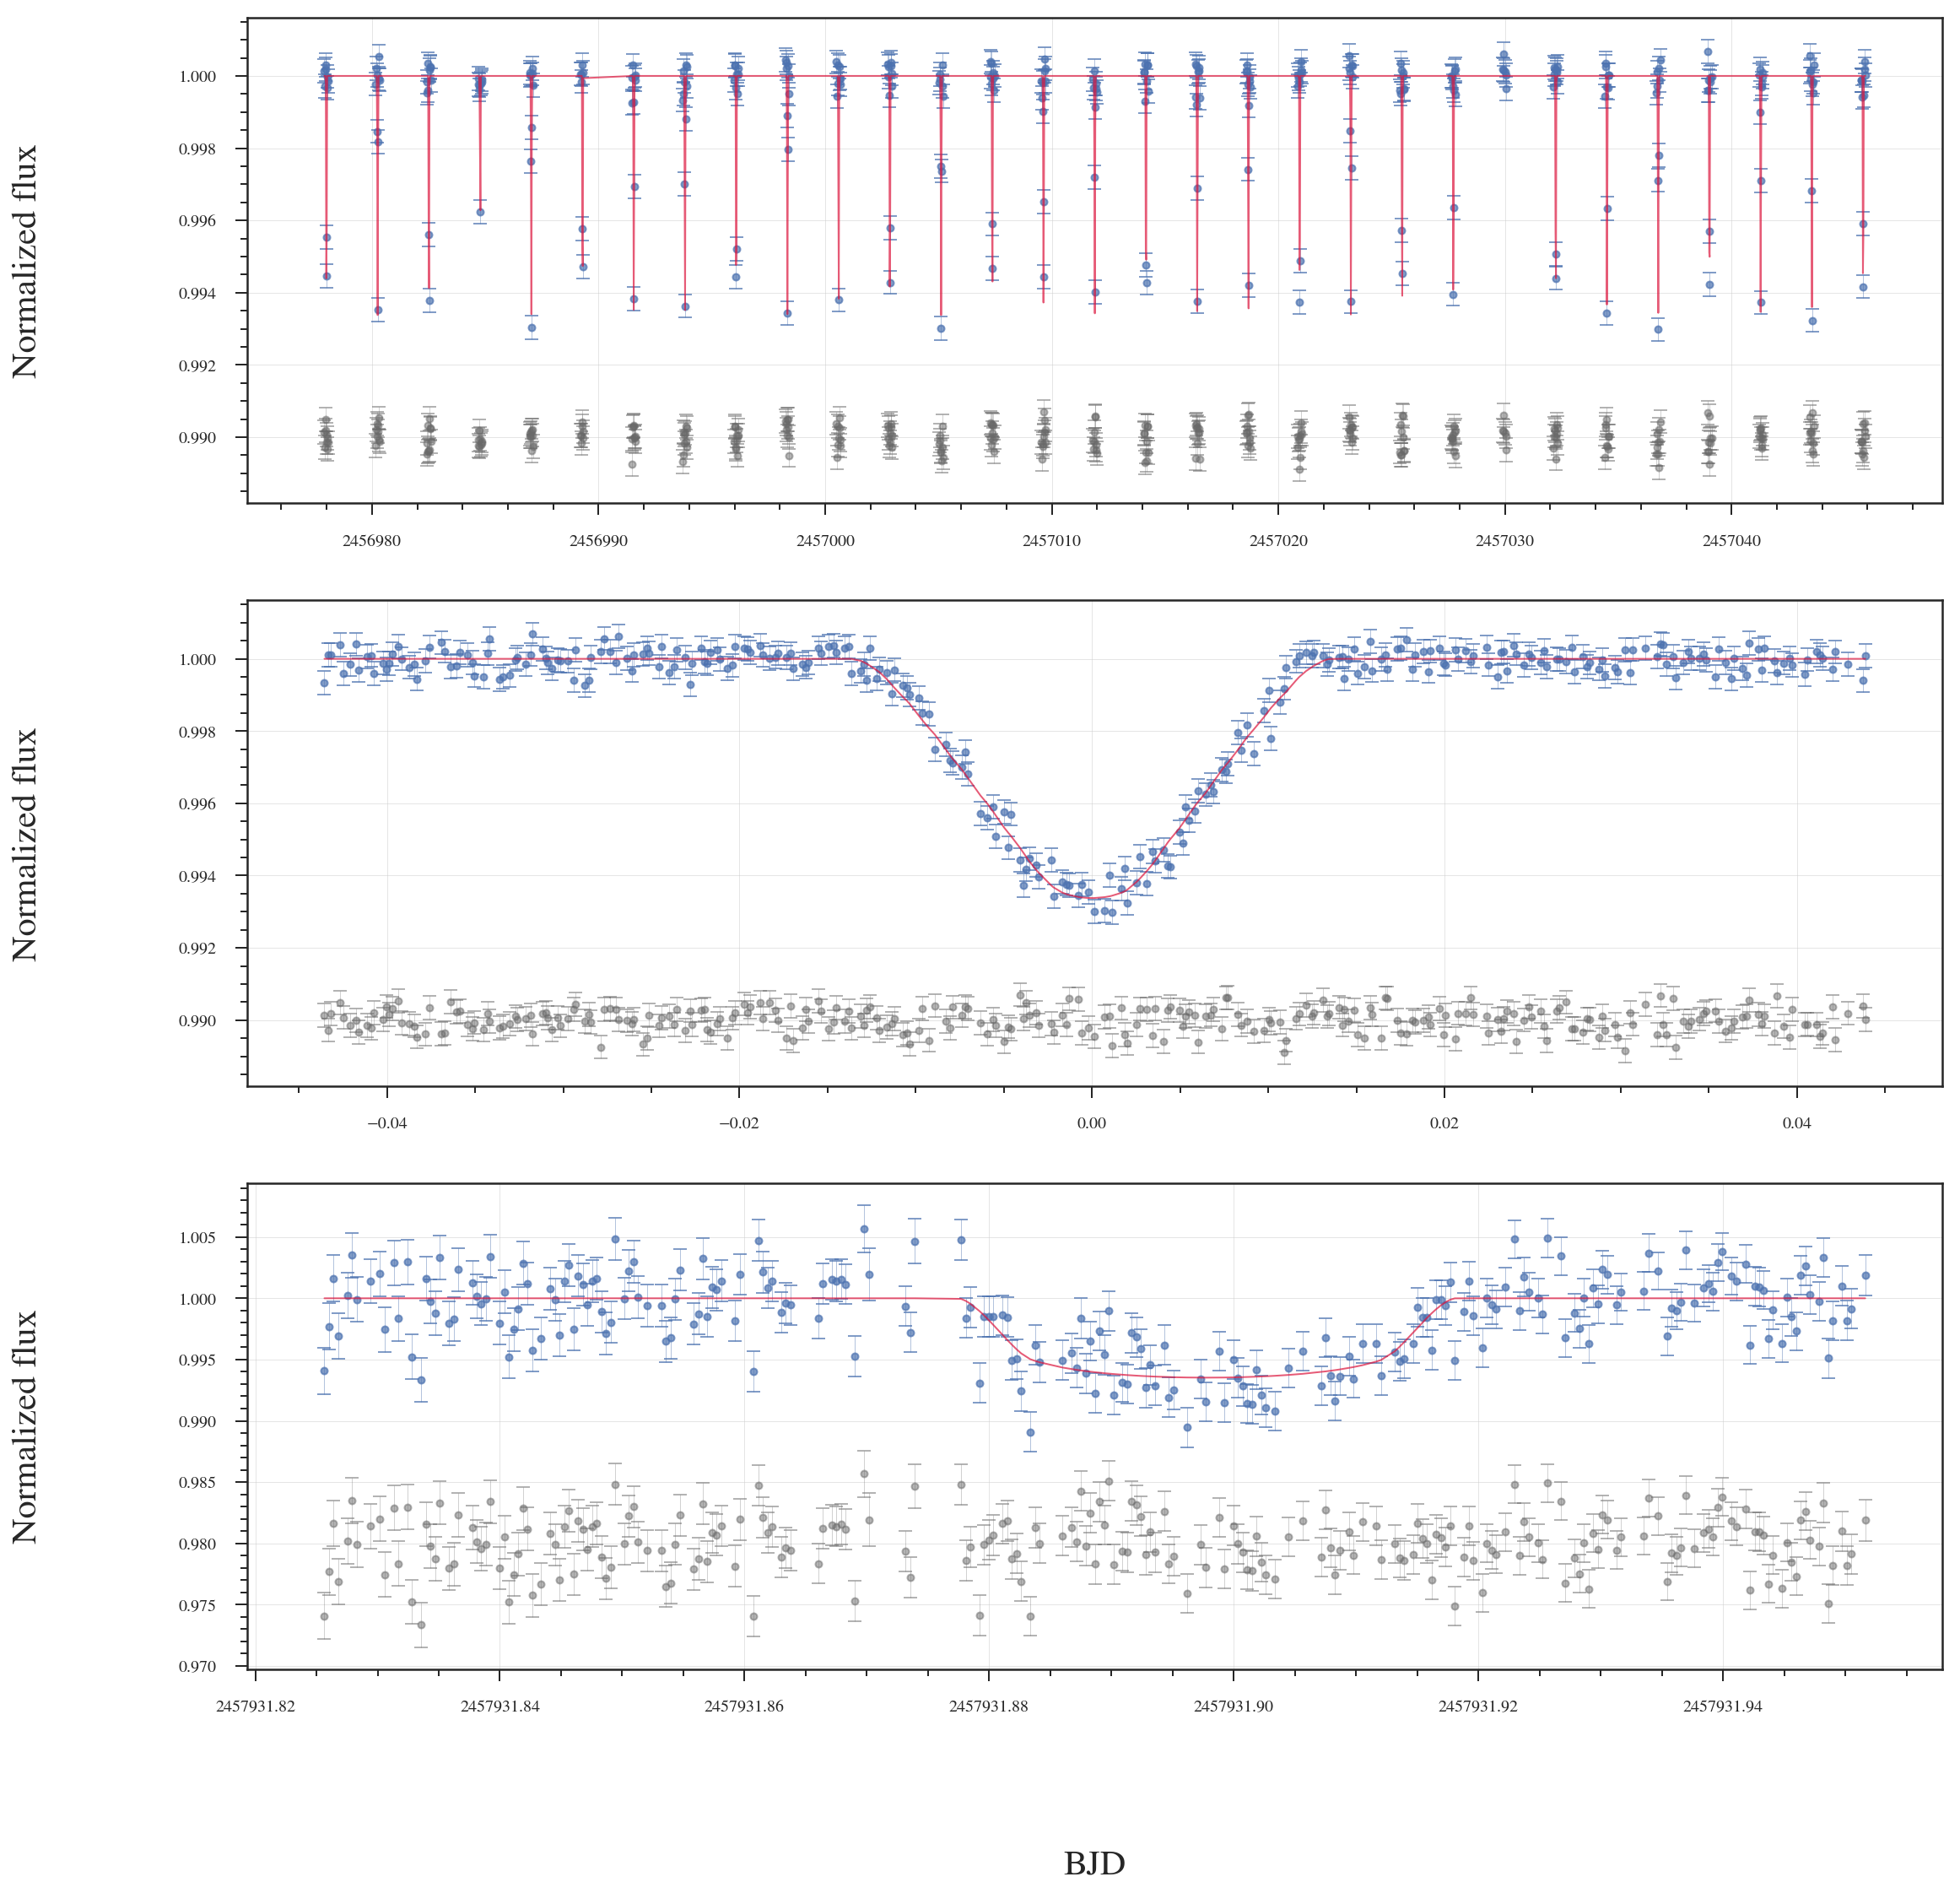

In [41]:
pv = TF.get_mean_values_mcmc_posteriors().medvals.values
t0  = TF.get_mean_values_mcmc_posteriors().medvals.values[0]
p  = 10.**TF.get_mean_values_mcmc_posteriors().medvals.values[1]
phases_data = utils.get_phases(TF.lpf.data1["time"],p,t0)
phases_fit = utils.get_phases(TF.lpf.data1["time"],p,t0)

model_trend1, model_trend2 = TF.lpf.compute_lc_model(pv)

scaled_flux1 = TF.lpf.data1["flux"]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_flux2 = TF.lpf.data2["flux"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

df_fold = pd.DataFrame(zip(phases_fit,model_trend1,scaled_flux1),columns=["phase","model","scaled_flux"]).sort_values("phase")

residual1 = scaled_flux1 - model_trend1
residual2 = scaled_flux2 - model_trend2

scaled_error1 = pv[TF.lpf.pv_lab2Idx("err1")]/pv[TF.lpf.pv_lab2Idx("fraw1")]
scaled_error2 = TF.lpf.data2["error"]/pv[TF.lpf.pv_lab2Idx("fraw2")]

# Plot transits
fig, axx = plt.subplots(nrows=3,figsize=(18,18))
ax,bx,cx = axx
plot_transits.plot_transit_with_model(TF.lpf.data1["time"],
                        scaled_flux1,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=TF.lpf.data1["time"],
                        ymodel=model_trend1,ax=ax)
plot_transits.plot_transit_with_model(df_fold.phase,
                        df_fold.scaled_flux,
                        scaled_error1,
                        yresidual=residual1,
                        xmodel=df_fold.phase,
                        ymodel=df_fold.model,ax=bx)
plot_transits.plot_transit_with_model(TF.lpf.data2["time"],
                        scaled_flux2,
                        scaled_error2,
                        yresidual=residual2,
                        xmodel=TF.lpf.data2["time"],
                        ymodel=model_trend2,
                        offset=0.98,ax=cx)

# Save files to plot in joint panel for paper

In [45]:
d = {'phase_fold_time_k2': df_fold.phase, 'phase_fold_scaled_flux_k2': df_fold.scaled_flux, 'scaled_error_k2':scaled_error1,
    'yresidual_k2': residual1, 'xmodel_k2':df_fold.phase, 'ymodel_k2':df_fold.model }
k2_data_for_plotting=pd.DataFrame(data=d)
k2_data_for_plotting.to_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_k2_final.csv")

In [46]:
d = {'time_ground': TF.lpf.data2["time"], 'scaled_flux_ground': scaled_flux2, 'scaled_error_ground':scaled_error2,
    'yresidual_ground': residual2, 'xmodel_ground': TF.lpf.data2["time"], 'ymodel_ground':model_trend2}
ground_data_for_plotting=pd.DataFrame(data=d)
ground_data_for_plotting.to_csv("../data/k2_28b/K2_data_k2_28b_for_plotting_ground_final.csv")